In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

If you want the result to be reproducible, you will need to set the seed.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Mount to Google drive and unpack your dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#import shutil
shutil.unpack_archive("/content/drive/MyDrive/Deep Learning/ISIC_balanced_split.zip", "/content/drive/MyDrive/Deep Learning/")

Run calculation on mean and standard deviation of my train dataset.

This is an additional code to check the mean and standard deviation of your dataset - you can then use it to replace the values in transforms.Normalize to improve your work.

In [ ]:
train_data = datasets.ImageFolder(root = '/content/drive/MyDrive/Deep Learning/ISIC_balanced_split/train/',
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.6938, 0.5495, 0.5302])
Calculated stds: tensor([0.1293, 0.1447, 0.1579])


Image resizing and image augmentation

In [ ]:
batch_size = 32
transform_train = transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    transforms.Resize((32,32)),
    #torchvision.transforms.RandomResizedCrop(32, scale=(0.08, 1.0),
    #                                         ratio=(3.0/4.0, 4.0/3.0)),
    transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    transforms.ToTensor(),
    # Standardize each channel of the image
    transforms.Normalize([0.6938, 0.5495, 0.5302],[0.1293, 0.1447, 0.1579])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    # Crop a 224 x 224 square area from the center of the image
    #torchvision.transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.6938, 0.5495, 0.5302],[0.1293, 0.1447, 0.1579])
   ])

Reading the dataset

In [ ]:
data_dir = '/content/drive/MyDrive/Deep Learning/ISIC_balanced_split/'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'valid']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['valid', 'ISIC2017_test']]

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

Show image - display some of your images for observation.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

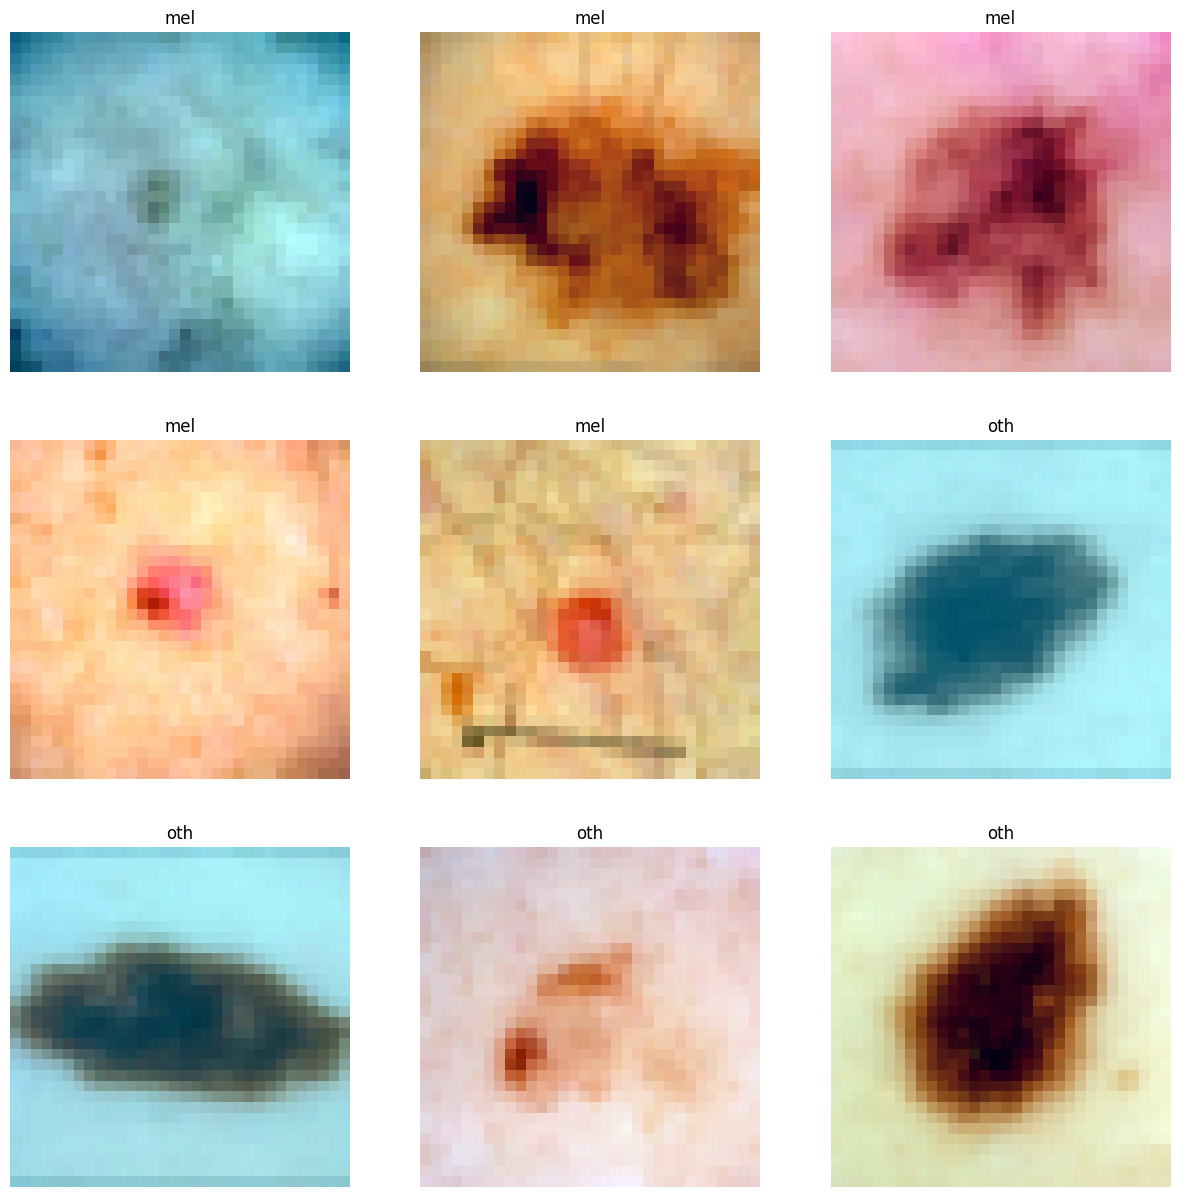

In [ ]:
N_IMAGES = 10
j=int(len(train_ds)/2) - int(N_IMAGES/2)

images, labels = zip(*[(image, label) for image, label in
                           [train_ds[i+j] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

Define the CNN - this example will focus on VGG
 and its variation. DO NOT CHANGE THE CODE IN THESE PARTS. MIT License: Copyright (c) 2018 Ben Trevett.

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

HERE you can start to define your model, you can use different vgg for your work. Change the OUTPUT_DIM to the number of classes.

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
#print(vgg11_layers)

OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)
#print(model)
pretrained_model = models.vgg11_bn(pretrained=True)
#print(pretrained_model)
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 70.5MB/s]


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,780,034 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
!pip install early-stopping-pytorch
from early_stopping_pytorch import EarlyStopping

early_stopping = EarlyStopping(patience=7, verbose=True)

EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.547832).  Saving model ...
Epoch: 01 | Epoch Time: 1m 16s
	Train Loss: 1.181 | Train Acc: 65.75%
	 Val. Loss: 0.548 |  Val. Acc: 75.46%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.547832 --> 0.543437).  Saving model ...
Epoch: 02 | Epoch Time: 1m 15s
	Train Loss: 0.578 | Train Acc: 72.36%
	 Val. Loss: 0.543 |  Val. Acc: 74.33%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch: 03 | Epoch Time: 1m 6s
	Train Loss: 0.554 | Train Acc: 73.70%
	 Val. Loss: 0.545 |  Val. Acc: 75.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.543437 --> 0.527048).  Saving model ...
Epoch: 04 | Epoch Time: 1m 10s
	Train Loss: 0.545 | Train Acc: 74.76%
	 Val. Loss: 0.527 |  Val. Acc: 73.57%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.527048 --> 0.496715).  Saving model ...
Epoch: 05 | Epoch Time: 1m 12s
	Train Loss: 0.540 | Train Acc: 74.60%
	 Val. Loss: 0.497 |  Val. Acc: 74.80%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss decreased (0.496715 --> 0.482038).  Saving model ...
Epoch: 06 | Epoch Time: 1m 13s
	Train Loss: 0.534 | Train Acc: 74.91%
	 Val. Loss: 0.482 |  Val. Acc: 75.72%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch: 07 | Epoch Time: 1m 6s
	Train Loss: 0.532 | Train Acc: 74.94%
	 Val. Loss: 0.490 |  Val. Acc: 76.95%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Epoch: 08 | Epoch Time: 1m 6s
	Train Loss: 0.509 | Train Acc: 75.45%
	 Val. Loss: 0.487 |  Val. Acc: 77.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Epoch: 09 | Epoch Time: 1m 6s
	Train Loss: 0.541 | Train Acc: 75.54%
	 Val. Loss: 0.491 |  Val. Acc: 75.10%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 7
Epoch: 10 | Epoch Time: 1m 5s
	Train Loss: 0.502 | Train Acc: 75.96%
	 Val. Loss: 0.500 |  Val. Acc: 77.51%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7
Epoch: 11 | Epoch Time: 1m 4s
	Train Loss: 0.512 | Train Acc: 76.99%
	 Val. Loss: 0.497 |  Val. Acc: 77.72%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 7
Epoch: 12 | Epoch Time: 1m 5s
	Train Loss: 0.488 | Train Acc: 76.47%
	 Val. Loss: 0.491 |  Val. Acc: 77.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

EarlyStopping counter: 7 out of 7
Early stopping triggered


TODO: You can load the best model

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))

<ipython-input-20-f8ea9cd1c708>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model.pt'))


<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter)

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Deep Learning/ISIC_balanced_split/ISIC2017_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

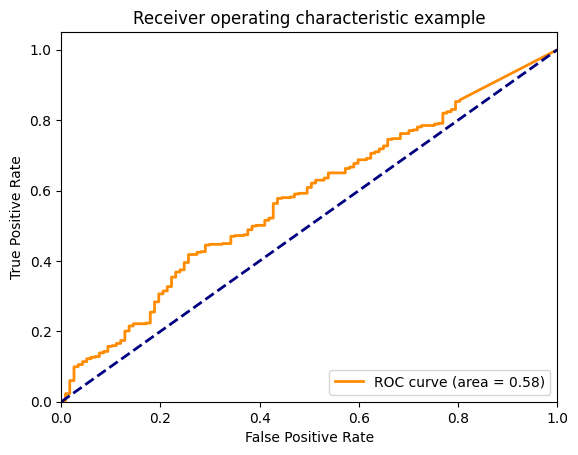

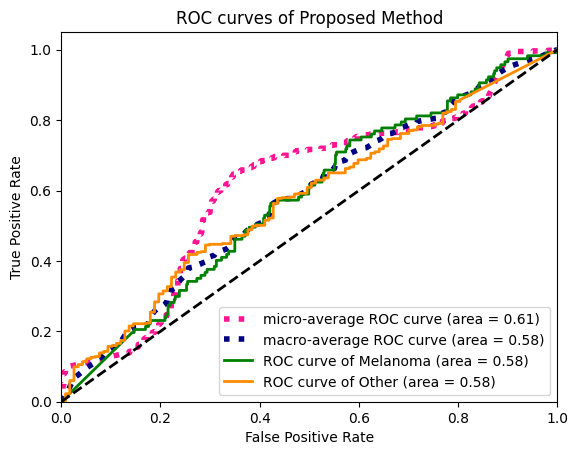

In [ ]:
from itertools import cycle
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
#from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[ 41  76]
 [136 347]]
[0 1]
[117 483]
[[117. 117.]
 [483. 483.]]


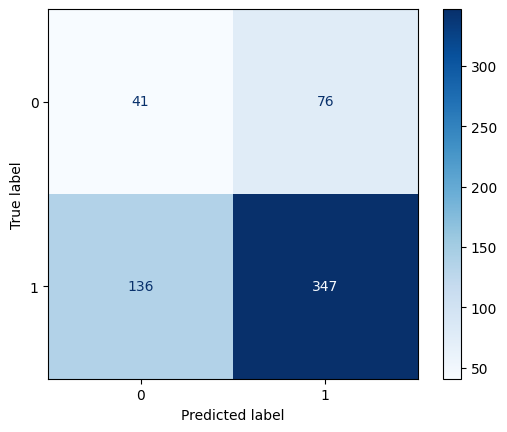

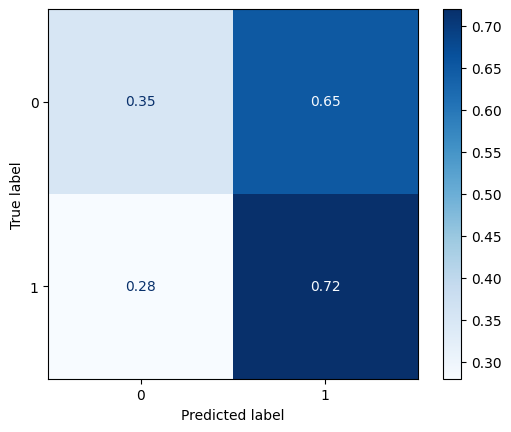

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 117
divisor[1][:] = 483
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

pred_class = np.argmax(probs, axis=1)
true_class = np.argmax(y_test, axis=1)

precision = precision_score(true_class, pred_class, average='weighted')
recall = recall_score(true_class, pred_class, average='weighted')
f1 = f1_score(true_class, pred_class, average='weighted')

print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-score (Weighted): {f1:.2f}")



Precision (Weighted): 0.71
Recall (Weighted): 0.65
F1-score (Weighted): 0.67


In [ ]:
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP

precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

weights = cm.sum(axis=1) / cm.sum()
precision_weighted = np.sum(precision_per_class * weights)
recall_weighted = np.sum(recall_per_class * weights)
f1_weighted = np.sum(f1_per_class * weights)


print(f"Precision (Weighted): {precision_weighted:.2f}")
print(f"Recall (Weighted): {recall_weighted:.2f}")
print(f"F1-score (Weighted): {f1_weighted:.2f}")

Precision (Weighted): 0.71
Recall (Weighted): 0.65
F1-score (Weighted): 0.67


This is optional visualisation for those who are interested in interpreting their results. MIT License: Copyright (c) 2018 Ben Trevett.

In [ ]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

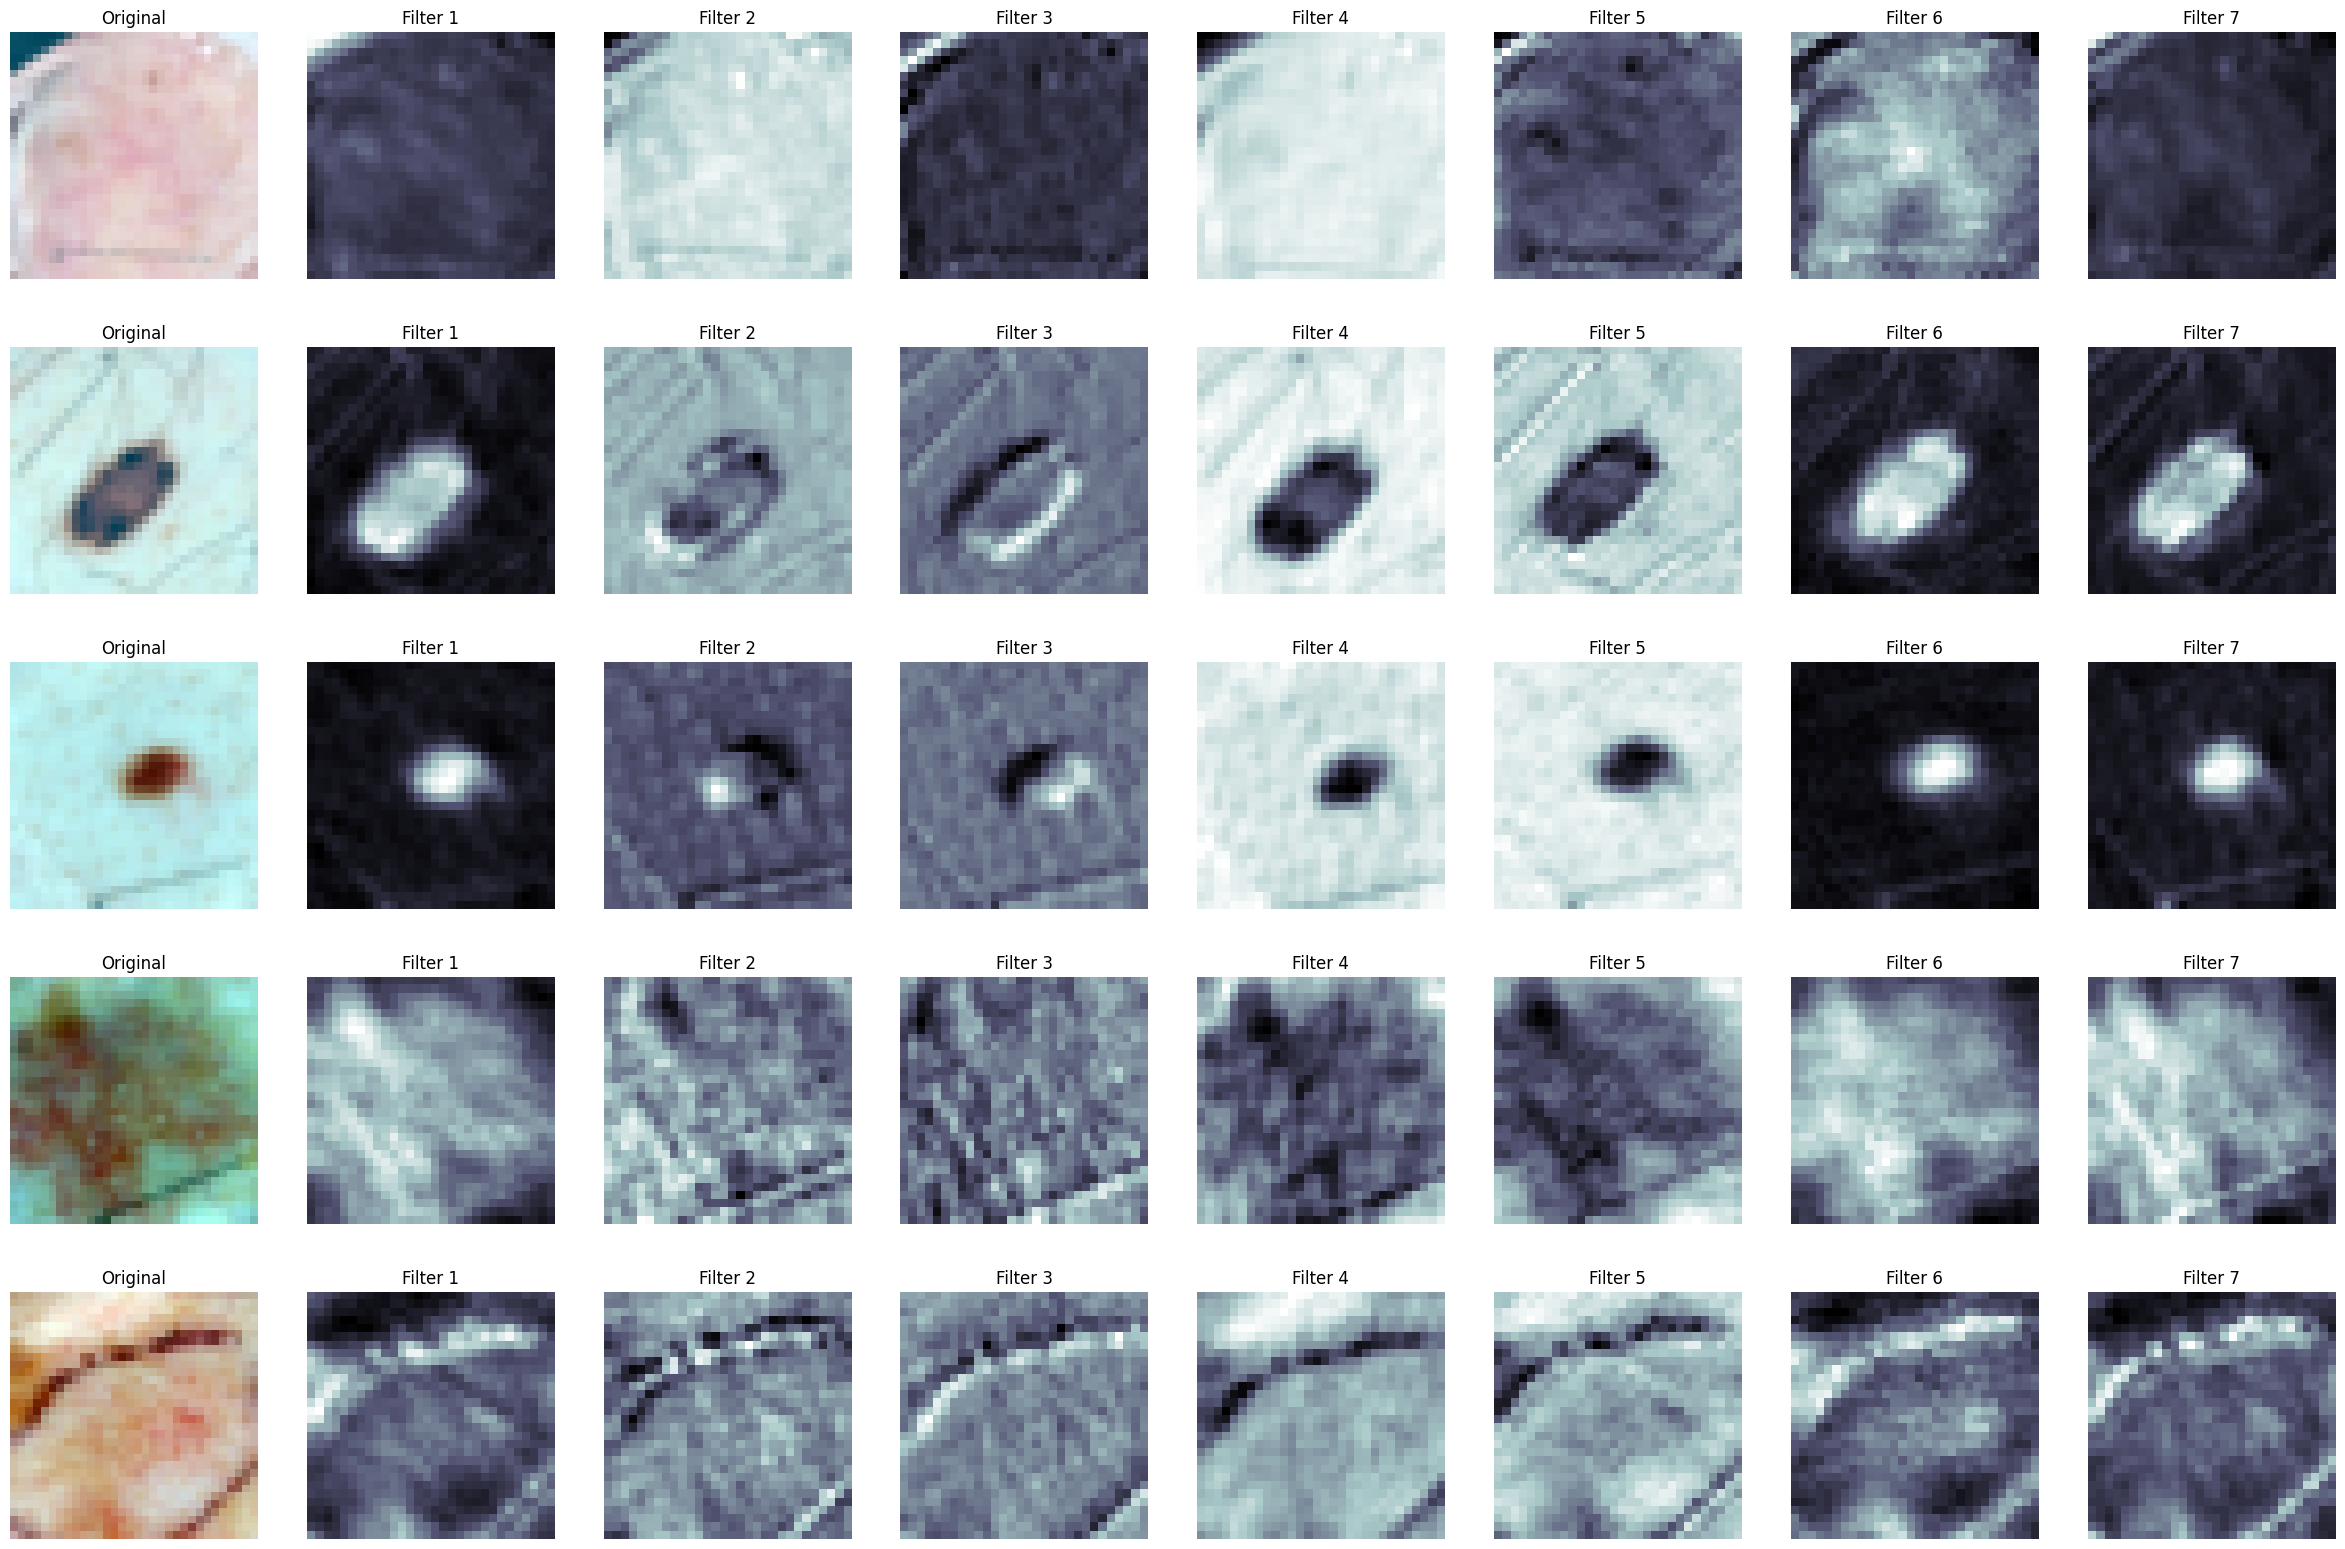

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_ds[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

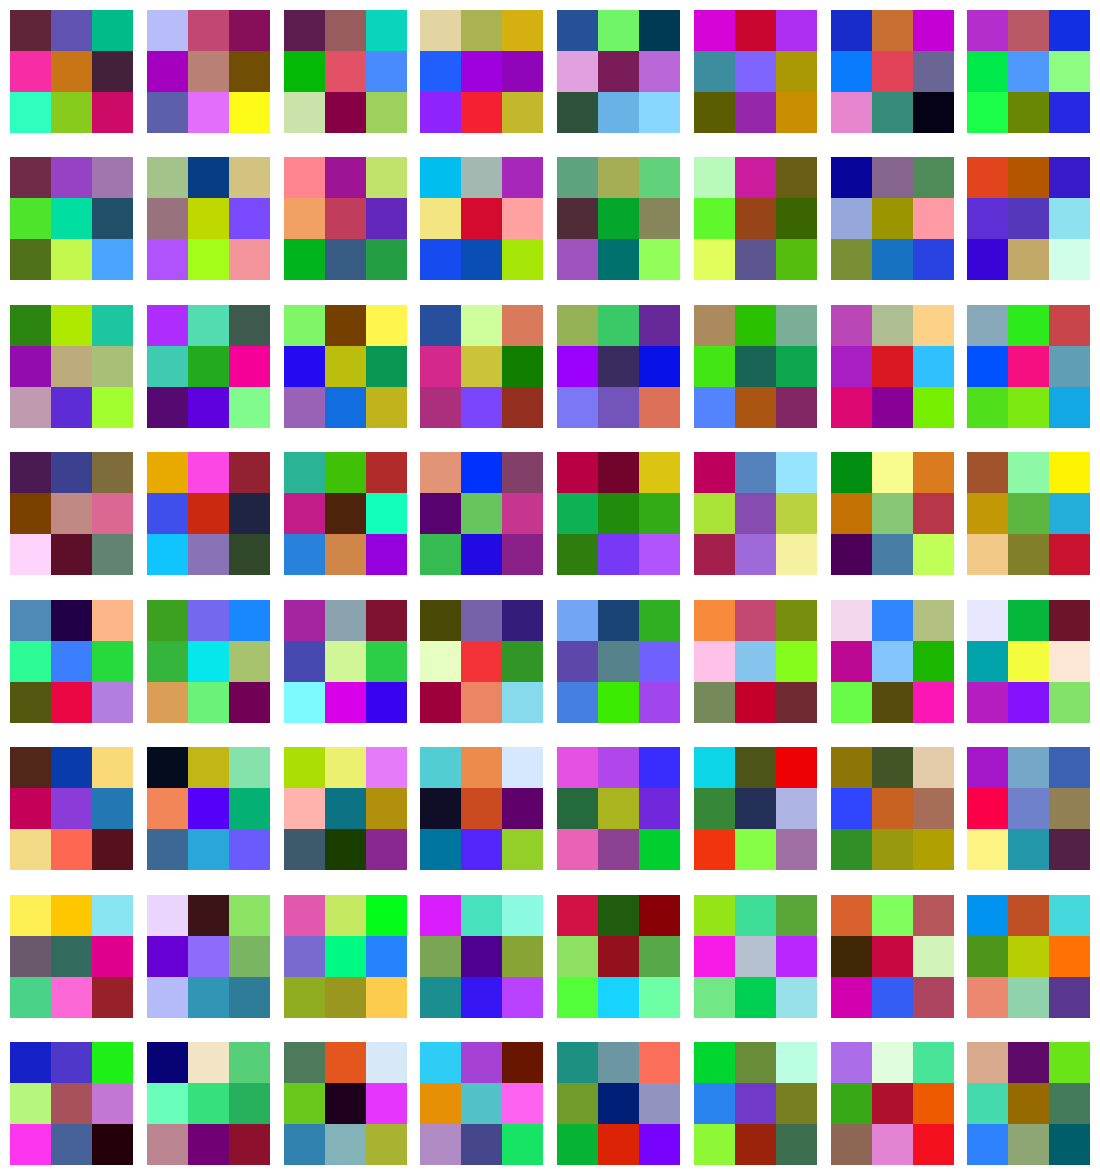

In [ ]:
plot_filters(filters)